#Use Case D - DeepPavlov (using BERT) 



* This is a Google Colab notebook. You must have a Google account with a Google Drive to store/ load the model. Upload it from its location in GitHub and allow the code to access your Google Drive.
* Please put your credentials in the cell "Connect to the Virtuoso database".
* Please run the first cell under "Installations" first. This will install DeepPavlov and it may ask you to restart the runtime.
* Fine-tuning can be skipped if already run once. Go to cell "Loading the fine-tuned model", load the saved model and continue.
* See instructions in cell "Configurations" to change the bi-encoder model, to select if you want to see intermediate results when interacting with chatbot, or to change the inputs - full set of proposals (datasets or SE Glossary articles).

### Installations

In [1]:
!pip install deeppavlov

     |████████████████████████████████| 878 kB 4.8 MB/s 
     |████████████████████████████████| 65 kB 4.7 MB/s 
     |████████████████████████████████| 57 kB 6.8 MB/s 
     |████████████████████████████████| 8.2 MB 63.3 MB/s 
     |████████████████████████████████| 859 kB 65.3 MB/s 
     |████████████████████████████████| 3.8 MB 37.5 MB/s 
     |████████████████████████████████| 2.9 MB 46.6 MB/s 
     |████████████████████████████████| 76 kB 4.1 MB/s 
     |████████████████████████████████| 55 kB 4.6 MB/s 
     |████████████████████████████████| 40 kB 15 kB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 654 kB 51.7 MB/s 
     |████████████████████████████████| 2.1 MB 15.4 MB/s 
     |████████████████████████████████| 7.3 MB 36.0 MB/s 
     |████████████████████████████████| 1.5 MB 43.9 MB/s 
     |████████████████████████████████| 10.4 MB 51.4 MB/s 
     |████████████████████████████████| 6.7 MB 52.8 MB/s 
     |█████████████████████

In [1]:
!apt-get install virtuoso-opensource

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  libvirtodbc0 virtuoso-opensource-6.1 virtuoso-opensource-6.1-bin
  virtuoso-opensource-6.1-common virtuoso-server virtuoso-vad-conductor
  virtuoso-vsp-startpage
Suggested packages:
  virtuoso-vad-doc virtuoso-vad-demo virtuoso-vad-tutorial
  virtuoso-vad-rdfmappers virtuoso-vad-sparqldemo virtuoso-vad-syncml
  virtuoso-vad-bpel virtuoso-vad-isparql virtuoso-vad-ods virtuoso-vad-dbpedia
  virtuoso-vad-facetedbrowser
The following NEW packages will be installed:
  libvirtodbc0 virtuoso-opensource virtuoso-opensource-6.1
  virtuoso-opensource-6.1-bin virtuoso-opensource-6.1-common virtuoso-server
  virtuoso-vad-conductor virtuoso-vsp-startpage
0 upgraded, 8 newly installed, 0 to

In [2]:
!pip install pyodbc

     |████████████████████████████████| 280 kB 5.0 MB/s 
  Created wheel for pyodbc: filename=pyodbc-4.0.32-cp37-cp37m-linux_x86_64.whl size=287332 sha256=70bd55eb94afc6b75bdaacdae6b312eee56ef595530484a2415d84e711549980
  Stored in directory: /root/.cache/pip/wheels/2e/9c/da/8652fd42e0f662015554f00a9e96fe4f438dfd1ef59787879e
Successfully built pyodbc


In [3]:
!pip install sentence-transformers

     |████████████████████████████████| 79 kB 3.1 MB/s 
     |████████████████████████████████| 4.2 MB 28.7 MB/s 
     |████████████████████████████████| 1.2 MB 58.4 MB/s 
     |████████████████████████████████| 84 kB 3.3 MB/s 
     |████████████████████████████████| 596 kB 55.8 MB/s 
     |████████████████████████████████| 6.6 MB 50.1 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=6c083a32c2f4143619be88006cdb33483e59c076f1f73b74219e1238bd149692
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
!pip install gap-stat

###Imports

In [5]:
import os, re, json, ast, random

from collections import defaultdict
from typing import List, Set, Tuple
from pathlib import Path

import nltk, pyodbc, sklearn, torch
import pandas as pd
import numpy as np
import ipywidgets as widgets

from google.colab import data_table, drive

from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

from sentence_transformers import SentenceTransformer, CrossEncoder, util
from sentence_transformers.losses import MultipleNegativesRankingLoss
from sentence_transformers.readers import LabelSentenceReader, InputExample
from torch.utils.data import DataLoader

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

from deeppavlov import build_model
from deeppavlov.core.common.registry import register
from deeppavlov.core.models.component import Component

import matplotlib.pyplot as plt

from gap_statistic import OptimalK

###Configurations

Please note that, once, the fine-tuning has been run, one can change any of the first two options and skip the fine-tuning (loading instead the saved model). For this, it suffices to:
*    Run only the cell with the selectors,
*    Run only the cell immediately after the selectors,
*    Go to the cell with the title “Loading the fine-tuned model” and choose 
“Runtime > Run after”, which runs the current cell and all following. 


In [6]:
# By Default it loads the first option to every dropdown menu

In [7]:
# Set which dataset to use (either eurostat's datasets or glossary articles)
data_dropdown = widgets.Dropdown(options=["datasets_use_case_d.pkl", "glossary_use_case_d.pkl"])
display(widgets.HBox([widgets.Label(value="Data:"), data_dropdown]))

# Option to show intermediate results when interacting with chatbot 
# Intermediate results include a histogram plot and a table for every chatbot interaction
intermediate_results_dropdown = widgets.Dropdown(options=["Yes", "No"])
display(widgets.HBox([widgets.Label(value="Show intermediate results?: "), intermediate_results_dropdown]))

### Select Bi-encoder model
# Load pre-trained model that we will use as a base for fine tuning or alone
# Warning: loading 2nd or 3rd model for finetuning requires large amounts of memory
bi_encoder_model_dropdown = widgets.Dropdown(options=["multi-qa-MiniLM-L6-cos-v1", "multi-qa-distilbert-cos-v1", "multi-qa-mpnet-base-cos-v1"])
display(widgets.HBox([widgets.Label(value="Bi-encoder model:"), bi_encoder_model_dropdown]))

In [76]:
dataset_to_load = data_dropdown.value
show_inter_results = True if intermediate_results_dropdown.value == 'Yes' else False
bi_encoder = SentenceTransformer(bi_encoder_model_dropdown.value)

In [60]:
path_to_bi_encoder = bi_encoder_model_dropdown.value

In [61]:
print('Settings chosen')
print(f'Data: {dataset_to_load}')
print(f'Show intermediate results?: {intermediate_results_dropdown.value}')
print(f'Bi-encoder model: {bi_encoder_model_dropdown.value}')

Settings chosen
Data: datasets_use_case_d.pkl
Show intermediate results?: Yes
Bi-encoder model: multi-qa-MiniLM-L6-cos-v1


###Auxiliary functions


In [11]:
def load_table(query):
  cursor.execute(query)
  t1 = cursor.fetchall()
  df = pd.DataFrame.from_records(t1, columns=[x[0] for x in cursor.description])
  return df

def clean(x, quotes=True):
    if pd.isnull(x): return x  
    x = x.strip()
    
    ## make letter-question mark-letter -> letter-quote-space-letter !!! but NOT in the lists of URLs!!!
    if quotes:
        x = re.sub(r'([A-Za-z])\?([A-Za-z])','\\1\' \\2',x) 
    
    ## make letter-question mark-space lower case letter letter-quote-space letter
    x = re.sub(r'([A-Za-z])\? ([a-z])','\\1\' \\2',x) 

    ## delete ,000 commas in numbers    
    x = re.sub(r'\b(\d+),(\d+)\b','\\1\\2',x) ## CORRECTED
    
    ## delete  000 spaces in numbers
    x = re.sub(r'\b(\d+) (\d+)\b','\\1\\2',x) ## CORRECTED
    
    ## remove more than one spaces
    x = re.sub(r' +', ' ',x)
    
    ## remove start and end spaces
    x = re.sub(r'^ +| +$', '',x,flags=re.MULTILINE) 
    
    ## space-comma -> comma
    x = re.sub(r' \,',',',x)
    
    ## space-dot -> dot
    x = re.sub(r' \.','.',x)
    
    x = re.sub(r'â.{2}',"'",x) ### !!! NEW: single quotes are read as: âXX
    
    return x


### Mount google drive

In [12]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


###Connect to Virtuoso database

In [13]:
c = pyodbc.connect('DRIVER=/usr/lib/odbc/virtodbc.so;HOST=lod.csd.auth.gr:1111;UID=kimon;PWD=RkhvQYZ442e2JVXLHdtW;DATABASE=ESTAT')


In [14]:
c.setdecoding(pyodbc.SQL_CHAR, encoding='latin-1')
c.setencoding(encoding="latin-1")

In [15]:
cursor = c.cursor()

###Loading the datasets information from the database

In [16]:
query_data = 'SELECT id, number, codes, names, file_descr, file_code, level, link FROM ESTAT.V1.dat_all_datasets'
crumbs_df = load_table(query_data)

crumbs_df['codes'] = crumbs_df['codes'].apply(lambda x: ast.literal_eval(x))
crumbs_df['names'] = crumbs_df['names'].apply(lambda x: ast.literal_eval(x))
crumbs_df.rename(columns={'number':'Number','codes':'Codes','names':'Names','file_descr':'File description',
                               'level':'Level','file_code':'File code','link':'Link'},inplace=True)

## keep only leaves - datasets
idx = crumbs_df[crumbs_df['File code']==''].index
crumbs_df.drop(index=idx, inplace=True) 
crumbs_df.reset_index(drop=True,inplace=True)

#crumbs_df['File description']=crumbs_df['Names'].apply(lambda x: x[-1]) 

crumbs_df['Full path'] = crumbs_df['Names'].apply(lambda x: [y for y in x[1:]]) ## exclude first part
crumbs_df['Full path'] = crumbs_df['Full path'].apply(lambda x: ' '.join(x))

crumbs_df = crumbs_df[['Number','Codes','Names','File description','File code','Level','Full path','Link']]

In [17]:
# Drop duplicates with the same file code
crumbs_df = crumbs_df.drop_duplicates(subset='File code', keep="first").reset_index()

### Loading glossary articles from the database


In [18]:
# query that needs to be calculated even if fine tuning is not needed
query1 = 'SELECT T1.id, T2.title, T1.definition, T2.url FROM ESTAT.V1.dat_glossary AS T1 INNER JOIN ESTAT.V1.dat_link_info AS T2 ON T1.id=T2.id WHERE T2.resource_information_id=1'
GL_df = load_table(query1)
# also keep a copy of this query results
glossary = GL_df.copy()

In [19]:
## Skip if already run
if 'File description' not in glossary.columns:
  glossary['definition'] = glossary['definition'].replace('', np.nan)
  glossary.dropna(axis=0,subset=['definition'], inplace=True)

  glossary.reset_index(drop=True, inplace=True)

In [20]:
## Skip if already run
if 'File description' not in glossary.columns:
  glossary['title'] = glossary['title'].apply(clean)
  glossary['title'] = glossary['title'].apply(lambda x: re.sub(r'\?','-',x)) ## also replace question marks by dashes
  # Edit titles in order to remove "Glossary:"
  glossary['title'] = glossary['title'].apply(lambda x: re.sub(r'Glossary:',' ',x)) 
  glossary['definition'] = glossary['definition'].apply(clean)

In [21]:
## Skip if already run
if 'File description' not in glossary.columns:
  # Drop The records with definitions "The revision ..." and "Redirect to ..." 
  idx = glossary[glossary['definition'].str.startswith('The revision #')].index
  glossary.drop(idx , inplace=True)
  idx = glossary[glossary['definition'].str.startswith('Redirect to')].index
  glossary.drop(idx , inplace=True)
  # dropping some pairs that definition is something generic with a link 
  idx = glossary[glossary['definition'].str.startswith('<Brief user-oriented definition')].index 
  glossary.drop(idx , inplace=True)

  glossary.reset_index(drop=True, inplace=True)

In [22]:
## Skip if already run
if 'File description' not in glossary.columns:
  glossary.rename(columns={'id':'article_id'},inplace=True)
  glossary.rename(columns={'url':'Link'},inplace=True)
  glossary.rename(columns={'definition':'File description'},inplace=True)

  glossary['Full path'] = glossary['title'] + '. ' + glossary['File description']

###Save datasets data

In [23]:
# save to pickle in order to be able to load it to DeepPavlov framework
crumbs_df.to_pickle('/content/drive/MyDrive/datasets_use_case_d.pkl')

In [24]:
# save to pickle in order to be able to load it to DeepPavlov framework
glossary.to_pickle('/content/drive/MyDrive/glossary_use_case_d.pkl')

In [25]:
del(crumbs_df,glossary)

###Fine tuning

#### Queries to get SE Glossary articles  

* Definitions from dat_glossary.
* Titles from dat_link_info (with resource_information_id=1, i.e. Eurostat, see ESTAT.V1.mod_resource_information).
* Match above on id.

#### Delete records with empty definitions and carry out data cleansing


In [26]:
GL_df['definition'] = GL_df['definition'].replace('', np.nan)
GL_df.dropna(axis=0,subset=['definition'],inplace=True)

GL_df.reset_index(drop=True, inplace=True)

GL_df['title'] = GL_df['title'].apply(clean)
GL_df['title'] = GL_df['title'].apply(lambda x: re.sub(r'\?','-',x)) ## also replace question marks by dashes
GL_df['definition'] = GL_df['definition'].apply(clean)

#### Delete "special" records

* i.e. redirections.

In [27]:
# Drop The records with definitions "The revision ..." and "Redirect to ..." 

idx = GL_df[GL_df['definition'].str.startswith('The revision #')].index
GL_df.drop(idx , inplace=True)
idx = GL_df[GL_df['definition'].str.startswith('Redirect to')].index
GL_df.drop(idx , inplace=True)
# dropping some pairs that definition is something generic with a link 
idx = GL_df[GL_df['definition'].str.startswith('<Brief user-oriented definition')].index 
GL_df.drop(idx , inplace=True)

GL_df.reset_index(drop=True, inplace=True)

GL_df.rename(columns={'id':'article_id'},inplace=True)
GL_df.rename(columns={'definition':'content'},inplace=True)

#### Add paragraphs titles and contents from the SE articles

* From dat_article_paragraph with abstract=0 (i.e. "no").
* Match article_id from dat_article_paragraph with id from dat_article.
* Carry out data cleansing on titles and paragraph contents.

In [28]:
query = 'SELECT article_id, title, content FROM ESTAT.V1.dat_article_paragraph WHERE abstract=0 AND article_id IN (SELECT id FROM ESTAT.V1.dat_article)'
add_content = load_table(query)

In [29]:
add_content['title'] = add_content['title'].apply(clean)
add_content['content'] = add_content['content'].apply(clean)

add_content['title'] = add_content['title'].replace('', np.nan)
add_content = add_content.dropna(axis=0,subset=['title'])
add_content['content'] = add_content['content'].replace('', np.nan)
add_content = add_content.dropna(axis=0,subset=['content'])

#### Query to get OECD Glossary data

In [30]:
query = "SELECT id, term,definition,context,theme FROM ESTAT.V1.OECD_Glossary"
OECD_df = load_table(query)

In [31]:
#apply cleaning
OECD_df['definition'] = OECD_df['definition'].apply(clean)
OECD_df['term'] = OECD_df['term'].apply(clean)
OECD_df['context'] = OECD_df['context'].apply(clean).apply(lambda x: re.sub(r'\. \. ','. ',x)).apply(lambda x: re.sub(r'\?','-',x)) ## also replace question marks by dashes
OECD_df['definition'] = OECD_df['definition'].apply(clean).apply(lambda x: re.sub(r'\. \. ','. ',x)).apply(lambda x: re.sub(r'\?','-',x)) ## also replace question marks by dashes

#renaming
OECD_df.rename(columns={'id':'article_id'},inplace=True)
OECD_df.rename(columns={'term':'title'},inplace=True)

# using title-definition pairs
OECD_df1 = OECD_df[['article_id','title','definition']]
OECD_df1 = OECD_df1.rename(columns={'definition':'content'})

# using title-context pairs
OECD_df2 = OECD_df[['article_id','title','context']].copy()
OECD_df2 = OECD_df2.rename(columns={'context':'content'})

OECD_df1 = OECD_df1[['article_id','title','content']].copy()
OECD_df2 = OECD_df2[['article_id','title','content']].copy()

# deleting empty
OECD_df1['content'] = OECD_df1['content'].replace('', np.nan)
OECD_df1 = OECD_df1.dropna(axis=0,subset=['content'])
OECD_df1['title'] = OECD_df1['title'].replace('', np.nan)
OECD_df1 = OECD_df1.dropna(axis=0,subset=['title'])

OECD_df2['content'] = OECD_df2['content'].replace('', np.nan)
OECD_df2 = OECD_df2.dropna(axis=0,subset=['content'])
OECD_df2['title'] = OECD_df2['title'].replace('', np.nan)
OECD_df2 = OECD_df2.dropna(axis=0,subset=['title'])

####Abstracts and context sections from SE articles

In [32]:
query = 'SELECT T1.id, T1.context, T2.title, T3.content FROM ESTAT.V1.dat_article as T1 INNER JOIN ESTAT.V1.dat_link_info as T2 ON T1.id=T2.id INNER JOIN ESTAT.V1.dat_article_paragraph as T3 ON T2.id=T3.article_id WHERE T2.resource_information_id=1 AND T3.abstract=1'
SE_df = load_table(query)

In [33]:
SE_df.rename(columns={'id':'article_id','content':'abstract'},inplace=True)

In [34]:
# apply cleaning
SE_df['title'] = SE_df['title'].apply(clean).apply(lambda x: re.sub(r'\?','-',x)) ## also replace question marks by dashes
SE_df['context'] = SE_df['context'].apply(clean)
SE_df['abstract'] = SE_df['abstract'].apply(clean)

# using title-context pairs
SE_df1 = SE_df[['article_id','title','context']]
SE_df1 = SE_df1.rename(columns={'context':'content'})

# using title-abstract pairs
SE_df2 = SE_df[['article_id','title','abstract']]
SE_df2 = SE_df2.rename(columns={'abstract':'content'})

# deleting empty
SE_df1['content'] = SE_df1['content'].replace('', np.nan)
SE_df1 = SE_df1.dropna(axis=0,subset=['content'])

SE_df2['content'] = SE_df2['content'].replace('', np.nan).replace('nan', np.nan)
SE_df2 = SE_df2.dropna(axis=0,subset=['content'])

####Merging all available glossaries and articles

In [35]:
# merge OECD glossary with add_content, GL_df and SE_df
glossaries = [OECD_df1, OECD_df2, GL_df, add_content, SE_df1, SE_df2]
merged_glossary = pd.concat(glossaries, ignore_index=True)
merged_glossary = merged_glossary.drop(['url'],axis=1)

del(OECD_df,OECD_df1, OECD_df2, GL_df, add_content, SE_df, SE_df1, SE_df2, glossaries)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [36]:
# setting all pairs of titles and content to have a label of 1
# this is because all pairs are considered a positive example
merged_glossary['is_pair']=1

#### Keep 80% of data for training and 20% for evaluation of the model

In [37]:
from sklearn.model_selection import train_test_split
train_features, eval_features, train_labels, eval_labels = train_test_split(merged_glossary[['title','content']], 
                                                                            merged_glossary[['is_pair']], 
                                                                            train_size=0.8, 
                                                                            random_state=1,
                                                                            stratify=merged_glossary['is_pair'])

train_features = train_features.reset_index(drop=True)
eval_features = eval_features.reset_index(drop=True)

####Fine tuning bi-encoder (CUDA required)

In [38]:
# convert training examples to the appropriate format
train_examples = []
for i in range(len(train_features)):
  train_examples.append(InputExample(texts=[train_features['title'].iloc[i], train_features['content'].iloc[i]]))

In [39]:
finetune_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)

In [40]:
# MultipleNegativesRankingLoss is a great loss function if you only have positive pairs 
loss = MultipleNegativesRankingLoss(model=bi_encoder)

In [41]:
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, BinaryClassificationEvaluator, MSEEvaluator
from sentence_transformers import evaluation

sentences1 = list(eval_features['title'])
sentences2 = list(eval_features['content'])
scores_eval = list(eval_labels['is_pair'])

In [42]:
evaluator = evaluation.MSEEvaluator(sentences1, sentences2, teacher_model=bi_encoder)

In [43]:
#cleaning up any CUDA related left-overs
import gc
gc.collect()

52

In [44]:
# Fine-tune the model (BE CAREFUL TO SET A PATH FOR THE FINE-TUNED MODEL)
num_epochs = 5
path_to_save_bi_encoder = '/content/drive/MyDrive/testing_fine_tuning'
bi_encoder.fit(train_objectives=[(finetune_dataloader, loss)], evaluator=evaluator, optimizer_class=torch.optim.AdamW, epochs=num_epochs, output_path=path_to_save_bi_encoder)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/744 [00:00<?, ?it/s]

Iteration:   0%|          | 0/744 [00:00<?, ?it/s]

Iteration:   0%|          | 0/744 [00:00<?, ?it/s]

Iteration:   0%|          | 0/744 [00:00<?, ?it/s]

Iteration:   0%|          | 0/744 [00:00<?, ?it/s]

####Loading the fine-tuned model

In [77]:
fine_tuned_bi_encoder = SentenceTransformer(path_to_save_bi_encoder)
path_to_bi_encoder = path_to_save_bi_encoder

In [78]:
bi_encoder = fine_tuned_bi_encoder

### DeepPavlov

#### Creating Components

In [79]:
# __init__ functions are called once in the very beggining of components initialization
# __call__ functions are called every time the user interacts with chatbot

In [80]:
@register('datasets_retriever')
class DatasetsRetriever(Component):
    def __init__(self, datasets_path: str, pretrained_model: str, top_n: int, path_column: str, **kwargs):
      self.model = SentenceTransformer(pretrained_model)
      self.datasets = pd.read_pickle(datasets_path)
      self.top_n = top_n

      # calculate corpus embeddings and augment dataset with these (so as to compute them only once)
      embeddings = self.model.encode(self.datasets[path_column], convert_to_tensor=True, show_progress_bar=False)
      self.datasets['embeddings'] = list(embeddings.cpu())

    def __call__(self, query: str, datasets: pd.DataFrame = None) -> pd.DataFrame:
      #calculate user's query embedding (initial or augmented)
      query_embedding = self.model.encode(query, convert_to_tensor=True, show_progress_bar=False)

      if datasets is None:
        data_df = self.datasets.copy()
      else:
        data_df = datasets.copy()
      
      data_df.reset_index(drop=True, inplace=True)
      data_df['corpus_id'] = data_df.index

      # top_n refers to number of Eurostat databases we want to retrieve with the bi-encoder
      hits = util.semantic_search(query_embedding, torch.stack(data_df['embeddings'].values.tolist()), top_k=self.top_n)
      hits = hits[0]
      hits_df = pd.DataFrame(hits)

      if 'score' in data_df.columns:
        data_df.drop(['score'], inplace=True, axis=1)
      
      # return the dataset augmented with two columns (bi-encoder corpus embeddings and score)
      data_df = hits_df.merge(data_df, on='corpus_id', how='inner')

      return data_df


@register('datasets_reranker')
class DatasetsReranker(Component):
    def __init__(self, pretrained_model:str, path_column: str, **kwargs):
      self.path_column = path_column
      self.model = CrossEncoder(pretrained_model)
        
    def __call__(self, query: str, top_n_datasets: pd.DataFrame) -> pd.DataFrame:
      # score all retrieved datasets with the cross_encoder
      cross_inp = [[query, top_n_datasets[self.path_column][i]] for i in range(len(top_n_datasets))]

      top_n_datasets['cross_scores'] = self.model.predict(cross_inp)
      top_n_datasets = top_n_datasets.sort_values(['cross_scores'],ascending=False)

      return top_n_datasets

@register('datasets_reducer')
class DatasetsReducer(Component):
    def __init__(self, **kwargs):
      pass
        
    def __call__(self, individual_query: str, intermediate_results:bool , datasets: pd.DataFrame) -> pd.DataFrame:
      # perform kmeans with 2 and 3 clusters on cross_scores, and only keep the cluster
      # that contains the result with best cross-score

      optimalK = OptimalK(clusterer = self._k_means_clustering)
      n_clusters = optimalK(datasets[['cross_scores']], cluster_array=np.arange(2, 4))
      print('Optimal clusters: ', n_clusters)
      print(optimalK.gap_df[['n_clusters', 'gap_value']])
      
      ## repeat with the optimal number of clusters between 2 and 3
      kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(datasets[['cross_scores']])

      datasets['cluster_id'] =  list(kmeans.labels_)

      # plot histogram
      if intermediate_results:
        ax = self._create_plot(datasets, n_clusters, individual_query)
        display(ax)

      datasets = datasets[datasets['cluster_id']==(datasets['cluster_id'].iloc[0])]
      return datasets

    def _k_means_clustering(self, data, num_of_clusters):
      # Include any clustering Algorithm that can return cluster centers
        m = KMeans(random_state=42, n_clusters=num_of_clusters)
        m.fit(data)
        # Return the location of each cluster center, and the labels for each point.
        return m.cluster_centers_, m.predict(data)
    

    def _create_plot(self, datasets, n_clusters, individual_query):
      # use a gray background
      ax = plt.axes(facecolor='#E6E6E6')
      ax.set_axisbelow(True)

      # draw solid white grid lines
      plt.grid(color='w', linestyle='solid')

      # hide axis spines
      for spine in ax.spines.values():
          spine.set_visible(False)
          
      # hide top and right ticks
      ax.xaxis.tick_bottom()
      ax.yaxis.tick_left()

      # lighten ticks and labels
      ax.tick_params(colors='gray', direction='out')
      for tick in ax.get_xticklabels():
          tick.set_color('gray')
      for tick in ax.get_yticklabels():
          tick.set_color('gray')

      for cluster in range(n_clusters):
        ax.hist(datasets['cross_scores'][(datasets['cluster_id'] == cluster)], 5, density=False, histtype='bar',  label='cluster '+str(cluster))
      ax.legend(prop={'size': 10})
      ax.set_xlabel('cross_scores')
      ax.set_title(f'Reduction phase, K-means clusters histogram query={individual_query}')
      plt.pause(0.05)
      return ax

@register('question_generator')
class QuestionGenerator(Component):
  def __init__(self, ngram_range: Tuple[int, int], max_df: float, min_df: float, **kwargs):
    self.ngram_range = ngram_range
    self.max_df = max_df
    self.min_df = min_df
  
  def __call__(self, corpus: pd.Series, stop_words: Set[str], unwanted_words: List[str]) -> Tuple[str, str, List[str]]:
    # exclude 'by' from stopwords (as we think that carries useful information)
    stop_words_copy = stop_words.copy()
    stop_words_copy.remove('by')
    vectorizer = TfidfVectorizer(stop_words=stop_words_copy, ngram_range=self.ngram_range, max_df=self.max_df, min_df=self.min_df, token_pattern='(?u)\\b\\w*[a-zA-Z%&\-/]+\\w*\\b|\\b[0-9]{4}\\b')
    subset = vectorizer.fit_transform(corpus)

    # a vocublulary of tokens that includes all ngrams that have been produced 
    vocabulary_words = vectorizer.get_feature_names()
    #print(vocabulary_words)

    # decide on the order that we want to show the user the ngrams (in the clarification question)
    sorted_word_idx = list(np.argsort(np.mean(subset.toarray(), axis=0)))

    # get the index of all unwanted words that are in the words dictionary
    existing_idx = list(map(lambda o: vectorizer.vocabulary_[o], filter(lambda o: o in vectorizer.vocabulary_, unwanted_words)))

    # making sure that the cleaned term will be removed from ngrams to propose
    sorted_idxs = [x for x in sorted_word_idx if x not in existing_idx]
    for idx in sorted_idxs[::-1]:
      question_word = vocabulary_words[idx]
      clean_term = self._clean_term_to_show(question_word)
      if clean_term not in unwanted_words:
        break
      else:
        pass

    question = f"bot: {self._choose_question(clean_term)} (yes/no/add some keywords, q to quit) \nme:  "  

    return question_word, question, vocabulary_words

  def _clean_term_to_show(self, input_term):
    # remove 'by' if it is the last token
    tokens = input_term.split()
    if tokens[-1]=='by':
      return ' '.join(tokens[:-1])
    return input_term

  def _choose_question(self, input_term):
  # function to produce a random question 
  
    input_tokens = input_term.split()
    # if ngram starts with 'by'
    if input_tokens[0]=='by':
      question_texts = [f"Would you like to see results {input_term}?", 
                        f"Would you be interested in seeing results {input_term}?",  
                        f"Let's make it more specific. Are you interested in seeing results {input_term}?"]
    # if ngram contains 3 or more tokens (this means that the question becomes very specific)
    elif len(input_tokens)>=3:
      question_texts = [f"What about {input_term}?"]
    else:
      question_texts = [f"Can we make it more specific? Is '{input_term}' related to what you are looking for?", 
                        f"Let's make it more specific. Are you interested in '{input_term}'?",
                        f"I have some results related to '{input_term}'. Is that what you are looking for?",
                        f"It would help me if could be could be more specific. Is '{input_term}' related to what you are searching?",
                        f"Would you be interested in '{input_term}'?",
                        f"Is '{input_term}' related to what you are looking for?",
                        f"It would help me if you could provide more details. Is '{input_term}' something related to your query?",
                        f"Please provide more details. Is '{input_term}' something related to what you are looking for?",
                        f"Are you interested to results related to '{input_term}'?",
                        f"Help me please to understand what you mean. Are you referring to '{input_term}'"
      ]
    return random.choice(question_texts)

@register('response_handler')
class ResponseHandler(Component):
  def __init__(self, **kwargs):
    self._stop_words = stopwords.words('english')
    self._stemmer = PorterStemmer()
  
  def __call__(self, question_word: str, input_text: str, answer_text: str, vocabulary_words: List[str], \
               all_unwanted_words: List[str], stop_after_multiple_yes: int, stop_after_multiple_no: int) -> Tuple[str, str, List[str],int, int]:

    if answer_text.lower()=='yes':
      # stop if you reach a threshold for "yes" answers from the user
      stop_after_multiple_yes = stop_after_multiple_yes - 1

      #update the initial query with the new ngram that we proposed (question_word)
      input_text = input_text + ' ' + question_word
      # find all terms that are similar to that ngram proposed and add them to the unwanted words
      all_unwanted_words.extend(self._similar_subset_terms(vocabulary_words, question_word))
      all_unwanted_words = list(set(all_unwanted_words))
      
      # make use of DeepPavlov's Component, to get the updated results based on the augmented user's answer
      return "retrieve_rerank", input_text, all_unwanted_words, stop_after_multiple_yes, stop_after_multiple_no
      ## query_results_df = self._retrieve_and_rerank(input_text, question_word, show_inter_results, query_results_df)

    elif answer_text.lower()=='no':
      # stop if you reach a threshold for "no" answers from the user
      stop_after_multiple_no = stop_after_multiple_no - 1

      # find all terms that are similar to that ngram proposed and add them to the unwanted words
      all_unwanted_words.extend(self._similar_superset_terms(vocabulary_words, question_word))
      all_unwanted_words = list(set(all_unwanted_words))
      return "check_stop", input_text, all_unwanted_words, stop_after_multiple_yes, stop_after_multiple_no

    # user can quit at any time
    elif answer_text.lower()=='q':
      ##break
      return "quit", None, None, None

    # allow user to define what ngrams NOT to ask
    elif answer_text.lower().startswith('no '):
      # treat as providing information
      stop_after_multiple_yes = stop_after_multiple_yes - 1 
      no_text = re.sub('no ','', answer_text)

      all_unwanted_words.extend(self._similar_superset_terms(vocabulary_words, question_word))
      for token in self._generate_ngrams1(no_text): 
        all_unwanted_words.extend(self._similar_superset_terms(vocabulary_words, token))
      all_unwanted_words = list(set(all_unwanted_words))
      return "check_stop", input_text, all_unwanted_words, stop_after_multiple_yes, stop_after_multiple_no   

    # in case that the user has entered a keyword/phrase/sentence instead of answering yes/no  
    else:
      # updating the threshold of yes
      stop_after_multiple_yes = stop_after_multiple_yes - 1

      # update the user's query with the text that they typed
      input_text = input_text + ' ' + answer_text
      # for every token that the user's answer contain
      for token in self._generate_ngrams1(answer_text):
        # find all terms that are similar to that ngram proposed and add them to the unwanted words
        all_unwanted_words.extend(self._similar_subset_terms(vocabulary_words, token))
      all_unwanted_words = list(set(all_unwanted_words))

      # make use of DeepPavlov's Component, to get the updated results based on the augmented user's answer
      return "retrieve_rerank", input_text, all_unwanted_words, stop_after_multiple_yes, stop_after_multiple_no
      ## query_results_df = self._retrieve_and_rerank(input_text, answer_text, show_inter_results, query_results_df)
        
  def _generate_ngrams1(self, input_text):
    # generate a list tha contains all 1 to 4 ngrams from input_text
    vectorizer1 = TfidfVectorizer(ngram_range=(1, 4))
    _ = vectorizer1.fit([input_text])
    input_ngrams = list(vectorizer1.get_feature_names())
    return input_ngrams
  
  # Notion behind this function is that when user answers 'yes' to a proposed ngram,
  # then they might be interested in more specific ngram (e.g. if asked
  # 'unemployment rate', would be interested in 'harmonised unemployment rate' also).
  # Simultaneously, the user would not want to see a repetition of a less specific ngram
  # (e.g. if asked for 'unemployment rate', wouldn't be interested in either
  # 'unemployment' or 'rates' to be asked again).
  # This function is used when we want to find all similar terms to input_term,
  # against the terms_list. We seek similar terms in terms_list.  If input term is
  # a superset of a (stemmed) term in the terms_list, then this is considered as similar.
  # Example:
  # input_term = unemployment rate
  # terms_list = [unemployment rate, unemployment rates, unemployment, rate, harmonised unemployment rate]
  # terms = [unemployment rate, unemployment rates, unemployment, rate]
  def _similar_subset_terms(self, terms_list, input_term):

    # input_term might be 1 or more tokens (usually words, numbers, etc)
    tokens = input_term.split() 
    # get all unique input tokens that are not stopwords
    tokens = set(filter(lambda o: not o in self._stop_words, tokens))
    if len(tokens)==0:
      return []

    # get the unique stemmed tokens
    stemmed_tokens = set(map(lambda o: self._stemmer.stem(o), tokens))

    terms = []
    for term in terms_list:
      stemmed_term = set(map(lambda o: self._stemmer.stem(o), term.split()))
      stemmed_term = set(filter(lambda o: not o in self._stop_words, stemmed_term))
      # issuperset returns true if stemmed_tokens is a superset of stemmed_term
      if stemmed_tokens.issuperset(stemmed_term):
        terms.append(term)
      
    return terms

  # Notion behind this function is that when user answers 'no' to a proposed ngram
  # or replies with their own phrase, then they might be interested in more generic
  # ngram (e.g. if asked 'educational attainment level' and answered 'no', might
  # be interested in 'educational' solely). Simultaneously, the user would not
  # want to see a more specific ngram (e.g. if asked for 'unemployment rate', wouldn't
  # be interested in 'unemployment rate by sex').
  # This function is used when we want to find all similar terms to input_term,
  # against the terms_list. We seek similar terms in terms_list.  If input term is
  # a subset of a (stemmed) term in the terms_list, then this is considered as similar.
  # Example:
  # input_term = unemployment rate
  # terms_list = [unemployment rate, unemployment rates, unemployment, rate, harmonised unemployment rate]
  # terms = [unemployment rate, unemployment rates, harmonised unemployment rate]
  def _similar_superset_terms(self, terms_list, input_term):

    # input_term might be 1 or more tokens (usually words, numbers, etc)
    tokens = input_term.split()
    # get all unique input tokens that are not stopwords
    tokens = set(filter(lambda o: not o in self._stop_words, tokens))
    if len(tokens)==0:
      return []

    # get the unique stemmed tokens
    stemmed_tokens = set(map(lambda o: self._stemmer.stem(o), tokens))

    terms = []
    for term in terms_list:
      stemmed_term = set(map(lambda o: self._stemmer.stem(o), term.split()))
      # issubset returns true if stemmed_tokens is a subset of stemmed_term
      if stemmed_tokens.issubset(stemmed_term):
        terms.append(term)
      
    return terms


#### JSON pipeline configurations

In [81]:
# An NLP pipeline config is a JSON file that contains one required element chainer, 
# which builds a pipeline from heterogeneous components (Rule-Based/ML/DL)

In [82]:
retrieve_and_rerank_config = {
    'chainer': {
        'in': ['query', 'individual_query', 'intermediate_results', 'datasets'],
        'pipe': [
            {
                'class_name': 'datasets_retriever',
                'id': 'datasets_retriever',
                'datasets_path': '{DATASETS_PATH}',
                'pretrained_model': f"{path_to_bi_encoder}",
                'path_column': 'Full path',
                'top_n': 100,
                'in': ['query', 'datasets'],
                'out': ['top_n_datasets']
            },
            {
                'class_name': 'datasets_reranker',
                'id': 'datasets_reranker',
                'pretrained_model': 'cross-encoder/ms-marco-MiniLM-L-6-v2',
                'path_column': 'Full path',
                'in': ['query', 'top_n_datasets'],
                'out': ['reranked_datasets']
            },
            {
                'class_name': 'datasets_reducer',
                'id': 'datasets_reducer',
                'in': ['individual_query', 'intermediate_results', 'reranked_datasets'],
                'out': ['reduced_datasets']
            }
        ],
        'out': ['reduced_datasets']
    },
    "metadata": {
      "variables": {
        "ROOT_PATH": "/content/drive/MyDrive/",
        "DATASETS_PATH": f"{{ROOT_PATH}}/{dataset_to_load}"
      }
  }
}

In [83]:
question_generator_config = {
    'chainer': {
        'in': ['corpus', 'stop_words', 'unwanted_words'],
        'pipe': [
            {
                'class_name': 'question_generator',
                'id': 'question_generator',
                'ngram_range': [2, 4],
                'max_df': 0.89,
                'min_df': 0.02,
                'in': ['corpus', 'stop_words', 'unwanted_words'],
                'out': ['question_token','question', 'vocabulary']
            }
        ],
        'out': ['question_token', 'question', 'vocabulary']
    }
}

In [84]:
response_handler_config = {
    'chainer': {
        'in': ['question_word', 'input_text', 'answer_text', 'vocabulary_words', 'all_unwanted_words', 'stop_after_multiple_yes', 'stop_after_multiple_no'],
        'pipe': [
            {
                'class_name': 'response_handler',
                'id': 'response_handler',
                'in': ['question_word', 'input_text', 'answer_text', 'vocabulary_words', 'all_unwanted_words', 'stop_after_multiple_yes', 'stop_after_multiple_no'],
                'out': ['outcome', 'input_text', 'all_unwanted_words', 'stop_after_multiple_yes', 'stop_after_multiple_no']
            }
        ],
        'out': ['outcome', 'input_text', 'all_unwanted_words', 'stop_after_multiple_yes', 'stop_after_multiple_no']
    }
}

## Databot

In [85]:
class Chatbot:
  def __init__(self):
    self._retrieve_and_rerank = build_model(retrieve_and_rerank_config)
    self._question_generator = build_model(question_generator_config)
    self._response_handler = build_model(response_handler_config)
    self._stop_words = stopwords.words('english')
    self._stemmer = PorterStemmer()

  def run(self, stop_after_multiple_no: int, stop_after_multiple_yes:int, show_inter_results:bool):
    input_text = input("bot: Hello, what are you looking for? \nme:  ")
    # make use of DeepPavlov's Component, that retrieves a number of datasets,
    # reranks them and then reduces the number of them based on clustering
    query_results_df = self._retrieve_and_rerank(input_text, input_text, show_inter_results, None)

    # initialize list, where we keep all ngrams that we do not  want to propose
    # to user (either the ones that user said no, or anything related to their query)
    all_unwanted_words = self._generate_ngrams(input_text)

    # keep asking the user for clarifications up until the results<=5, or if the
    # user replied with a predifined number of no's or yes
    while stop_after_multiple_yes>0 and stop_after_multiple_no>0 and len(query_results_df)>5:

      # display intermediate results
      if show_inter_results:
        query_results_df_to_show = query_results_df[['score', 'cross_scores', 'File description', 'Full path', 'Link']].copy()
        if (data_dropdown.value == 'glossary_use_case_d.pkl'):
          query_results_df_to_show['File description'] = query_results_df_to_show['File description'].str.slice(0,315) + "..."
          query_results_df_to_show['Full path'] = query_results_df_to_show['Full path'].str.slice(0,315) + "..."
        display(data_table.DataTable(query_results_df_to_show , num_rows_per_page=5))
      
      # make use of DeepPavlov's Component, that generates next question
      question_word, question, vocabulary_words = self._question_generator(query_results_df['File description'], self._stop_words, all_unwanted_words)
      if not question:
        break
      answer_text = input(question)

      outcome, input_text, all_unwanted_words, stop_after_multiple_yes, stop_after_multiple_no = \
        self._response_handler(question_word, input_text, answer_text, vocabulary_words, all_unwanted_words, stop_after_multiple_yes, stop_after_multiple_no)
      

      if outcome == 'retrieve_rerank':
        query_results_df = self._retrieve_and_rerank(input_text, question_word, show_inter_results, query_results_df)
      elif outcome == 'check_stop':
        pass  
      elif outcome == 'quit':
        break 
      
    # final results (truncated so as to show only top5 to the user)
    query_results_df = query_results_df.head(5)
    print('bot: Thank you. Here are the most relevant results of your query:')
    query_results_df_to_show = query_results_df[['score', 'cross_scores', 'File description', 'Full path', 'Link']].copy()
    if (data_dropdown.value == 'glossary_use_case_d.pkl'):
      query_results_df_to_show['File description'] = query_results_df_to_show['File description'].str.slice(0,315) + "..."
      query_results_df_to_show['Full path'] = query_results_df_to_show['Full path'].str.slice(0,315) + "..."
    display(data_table.DataTable(query_results_df_to_show, num_rows_per_page=10))

    return query_results_df



  def _generate_ngrams(self, input_text):
    # generate a list tha contains all 1 to 4 ngrams from input_text
    vectorizer1 = TfidfVectorizer(ngram_range=(1, 4))
    _ = vectorizer1.fit([input_text])
    input_ngrams = list(vectorizer1.get_feature_names())
    return input_ngrams


In [86]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

####Run chatbot

In [87]:
# create a Chatbot object
chatbot = Chatbot()

bot: Hello, what are you looking for? 
me:  pensions
Optimal clusters:  2
   n_clusters  gap_value
0         2.0   0.549207
1         3.0   0.211935


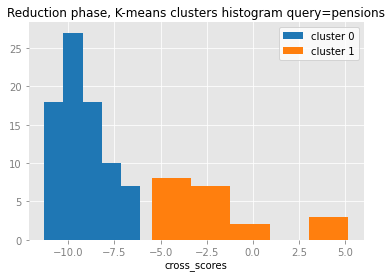

,score,cross_scores,File description,Full path,Link
2,0.525255,5.193029,Partial retirement pension : periodic payments...,Partial retirement pension. Partial retirement...,https://ec.europa.eu/eurostat/statistics-expla...
0,0.637172,4.779267,Expenditure on pensions comprises the followin...,Expenditure on pensions. Expenditure on pensio...,https://ec.europa.eu/eurostat/statistics-expla...
1,0.542893,3.448648,Old age pension : periodic payments intended t...,Old age pension. Old age pension : periodic pa...,https://ec.europa.eu/eurostat/statistics-expla...
3,0.510470,0.654281,Early retirement in case of reduced ability to...,Early retirement. Early retirement in case of ...,https://ec.europa.eu/eurostat/statistics-expla...
4,0.438764,0.221156,The aggregate replacement ratio is gross media...,Aggregate replacement ratio. The aggregate rep...,https://ec.europa.eu/eurostat/statistics-expla...
6,0.383441,-1.290709,Social transfers cover the social help given b...,Social transfers. Social transfers cover the s...,https://ec.europa.eu/eurostat/statistics-expla...
7,0.349986,-1.479293,Social benefits other than social transfers in...,Social benefits. Social benefits other than so...,https://ec.europa.eu/eurostat/statistics-expla...
14,0.290368,-1.639283,"Household saving, total savings of the househo...","Household saving. Household saving, total savi...",https://ec.europa.eu/eurostat/statistics-expla...
13,0.294190,-2.367859,The compensation of employees consists of all ...,Compensation. The compensation of employees co...,https://ec.europa.eu/eurostat/statistics-expla...
61,0.219547,-2.660372,"At risk of poverty or social exclusion, abbrev...",At risk of poverty or social exclusion. At ris...,https://ec.europa.eu/eurostat/statistics-expla...


bot: Are you interested to results related to 'social contributions'? (yes/no/add some keywords, q to quit) 
me:  yes
Optimal clusters:  2
   n_clusters  gap_value
0         2.0  -0.010085
1         3.0  -0.289445


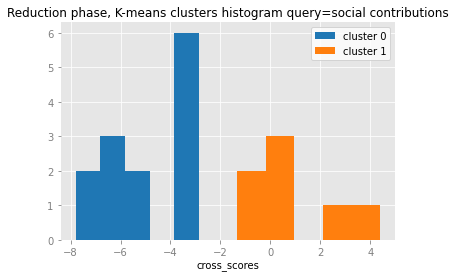

,score,cross_scores,File description,Full path,Link
3,0.524561,4.401008,Social contributions are paid on a compulsory ...,Social contributions. Social contributions are...,https://ec.europa.eu/eurostat/statistics-expla...
0,0.686875,2.731758,Expenditure on pensions comprises the followin...,Expenditure on pensions. Expenditure on pensio...,https://ec.europa.eu/eurostat/statistics-expla...
2,0.534756,0.641797,Social benefits other than social transfers in...,Social benefits. Social benefits other than so...,https://ec.europa.eu/eurostat/statistics-expla...
1,0.585663,0.474867,Social transfers cover the social help given b...,Social transfers. Social transfers cover the s...,https://ec.europa.eu/eurostat/statistics-expla...
9,0.369943,0.243787,The compensation of employees consists of all ...,Compensation. The compensation of employees co...,https://ec.europa.eu/eurostat/statistics-expla...
11,0.317027,-0.868241,"Household saving, total savings of the househo...","Household saving. Household saving, total savi...",https://ec.europa.eu/eurostat/statistics-expla...
7,0.429380,-1.331257,The European system of integrated social prote...,European system of integrated social protectio...,https://ec.europa.eu/eurostat/statistics-expla...


bot: Let's make it more specific. Are you interested in 'social protection'? (yes/no/add some keywords, q to quit) 
me:  yes
Optimal clusters:  2
   n_clusters  gap_value
0         2.0  -1.016903
1         3.0  -1.473506


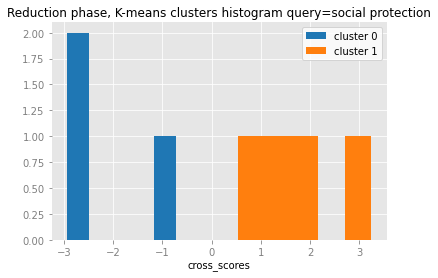

bot: Thank you. Here are the most relevant results of your query:


,score,cross_scores,File description,Full path,Link
3,0.493020,3.246397,Social contributions are paid on a compulsory ...,Social contributions. Social contributions are...,https://ec.europa.eu/eurostat/statistics-expla...
4,0.487518,1.890822,The European system of integrated social prote...,European system of integrated social protectio...,https://ec.europa.eu/eurostat/statistics-expla...
2,0.526289,1.172004,Social benefits other than social transfers in...,Social benefits. Social benefits other than so...,https://ec.europa.eu/eurostat/statistics-expla...
0,0.624964,0.527414,Expenditure on pensions comprises the followin...,Expenditure on pensions. Expenditure on pensio...,https://ec.europa.eu/eurostat/statistics-expla...


In [88]:
# You may also change parameter show_inter_results here, from show_inter_results to True or False
query_results_df = chatbot.run(stop_after_multiple_no=6, stop_after_multiple_yes=5, show_inter_results=show_inter_results)